# Porjet ML : Classification images

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


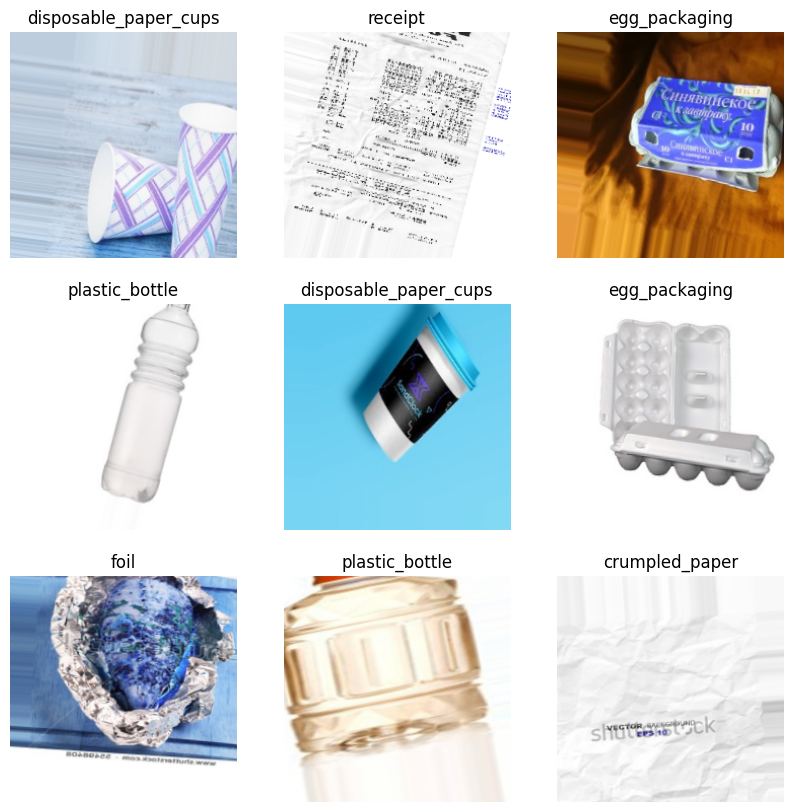

In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
from sklearn.preprocessing import LabelEncoder
import pickle

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_images_from_folder(folder):
    images = []
    labels = []  # Assuming subfolders in 'folder' are named after labels
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                try:
                    img = cv2.imread(img_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
                except Exception as e:
                    logging.error("Error loading image at {}: {}".format(img_path, e))
    return images, labels

def preprocess_images(images, size=(224, 224)):
    processed_images = []
    for img in images:
        try:
            img = cv2.resize(img, size)
            img = img / 255.0  # Normalize to [0, 1]
            processed_images.append(img)
        except Exception as e:
            logging.error("Error processing image: {}".format(e))
    return np.array(processed_images)

def augment_data(image_data_generator, images, labels):
    augmented_images, augmented_labels = [], []
    for x, y in image_data_generator.flow(images, labels, batch_size=1):
        augmented_images.append(x[0])
        augmented_labels.append(y[0])
        if len(augmented_images) == len(images):
            break
    return np.array(augmented_images), np.array(augmented_labels)

logging.info("Starting data preprocessing...")

# Load images

from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/dataset-master' # Google Drive path

# folder_path = 'dataset-master'  # Ipath to local folder
images, labels = load_images_from_folder(folder_path)
logging.info("Loaded {} images".format(len(images)))

# Create a label encoder object
label_encoder = LabelEncoder()
# Fit label encoder and return encoded labels
integer_encoded_labels = label_encoder.fit_transform(labels)
with open('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

# Preprocess images
processed_images = preprocess_images(images)
logging.info("Processed images")

# Data augmentation
image_data_generator = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
augmented_images, augmented_labels = augment_data(image_data_generator, processed_images, integer_encoded_labels)
logging.info("Augmented images")

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

logging.info("Dataset split into training, validation, and test sets")

# Example visualization
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    original_label = label_encoder.inverse_transform([y_train[i]])[0]
    plt.title(original_label)
    plt.axis("off")

logging.info("Data preprocessing completed.")

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(X_val.shape)

print(X_train[0])
print(y_train[0])

(1380, 224, 224, 3)
(1380,)
(461, 224, 224, 3)
(460, 224, 224, 3)
[[[0.34061813 0.45434362 0.32903954]
  [0.34589943 0.45962492 0.33256042]
  [0.35118073 0.46490622 0.33608127]
  ...
  [0.38431373 0.5058824  0.38431373]
  [0.38569134 0.5068843  0.38544086]
  [0.4268971  0.5366507  0.41897842]]

 [[0.33527312 0.44704482 0.32742998]
  [0.33263248 0.4452844  0.32478935]
  [0.32999182 0.44352394 0.32214868]
  ...
  [0.38431373 0.5058824  0.38431373]
  [0.3953737  0.513926   0.3933628 ]
  [0.40753236 0.5155255  0.39697304]]

 [[0.36527482 0.4806399  0.36113912]
  [0.35383204 0.46655646 0.3479359 ]
  [0.34238923 0.452473   0.33473265]
  ...
  [0.38431373 0.5058824  0.38431373]
  [0.4050561  0.5209677  0.40128475]
  [0.38816762 0.49440035 0.37496766]]

 ...

 [[0.4298111  0.5411765  0.41960785]
  [0.43529412 0.5411765  0.41744787]
  [0.43725398 0.54313636 0.41274464]
  ...
  [0.465418   0.57522196 0.46149644]
  [0.4601367  0.5699407  0.45621514]
  [0.45750085 0.5673048  0.45357928]]

 [[0.431

## II. Entrainement des modeles

### A. CNN Classique

#### 1) CNN Version 1 :

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
input_shape = (224, 224, 3)

model1 = Sequential([

    Input(shape=input_shape),

    # Première couche de convolution, 32 noyaux de 3x3
    Conv2D(32, (3, 3), input_shape=input_shape, padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Deuxième couche de convolution, 64 noyaux de 3x3
    Conv2D(64, (3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Troisième couche de convolution, 128 noyaux de 3x3
    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Couche de mise à plat, pour convertir les données 3D en un flux de données 1D
    Flatten(),

    # Couche entièrement connectée, 128 unités
    Dense(128),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.5),  # Couche de dropout pour réduire le surapprentissage

    # Couche de sortie, supposons 7 classes
    Dense(7),
    Activation('softmax')  # Utiliser softmax pour la classification multiple
])

# Résumé du modèle
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 activation_5 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 batch_normalization_5 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 activation_6 (Activation)   (None, 112, 112, 64)     

##### - Compiler le modèle

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                               mode = 'auto',
                               patience=10,
                               verbose=1)

model_checkpoint = ModelCheckpoint('model-cnn.h5',
                                   monitor='val_accuracy',
                                   mode = 'auto',
                                   save_best_only=True,
                                   verbose=1)

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Utiliser pour des étiquettes entières
              metrics=['accuracy'])

##### - Entraîner le modèle

In [ ]:
history1 = model1.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
43/44 [============================>.] - ETA: 0s - loss: 2.1867 - accuracy: 0.3365
Epoch 1: val_accuracy improved from -inf to 0.17174, saving model to model-cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 6s 77ms/step - loss: 2.1846 - accuracy: 0.3370 - val_loss: 3.3435 - val_accuracy: 0.1717
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 1.6437 - accuracy: 0.4587
Epoch 2: val_accuracy did not improve from 0.17174
44/44 [==============================] - 2s 55ms/step - loss: 1.6437 - accuracy: 0.4587 - val_loss: 2.6454 - val_accuracy: 0.1000
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 1.5034 - accuracy: 0.4891
Epoch 3: val_accuracy did not improve from 0.17174
44/44 [==============================] - 2s 54ms/step - loss: 1.5034 - accuracy: 0.4891 - val_loss: 3.1152 - val_accuracy: 0.1022
Epoch 4/100
44/44 [==============================] - ETA: 0s - loss: 1.1802 - accuracy: 0.6007
Epoch 4: val_accuracy did not improve from 0.17174
44/44 [==============================] - 2s 55ms/step - loss: 1.1802 - accuracy: 0.6007 - val_loss: 2.7844 - val_accuracy: 0.1043
Epoch 5/100
44/44 [=======================

In [ ]:
test_loss1, test_acc1 = model1.evaluate(X_test, y_test)
print('Test loss:', test_loss1)
print('Test accuracy:', test_acc1)

15/15 [==============================] - 0s 18ms/step - loss: 1.7757 - accuracy: 0.4881
Test loss: 1.7757097482681274
Test accuracy: 0.48806941509246826


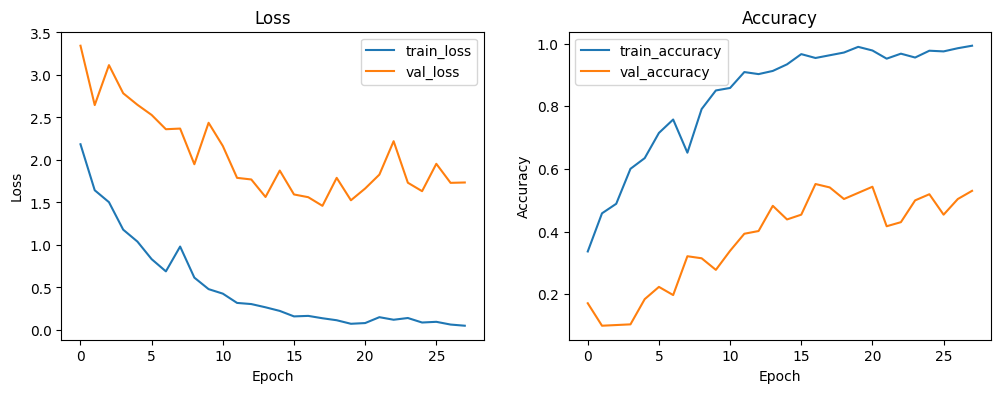

In [ ]:
import matplotlib.pyplot as plt

# Tracer les courbes de perte pour la formation et la validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='train_loss')
plt.plot(history1.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer les courbes de précision pour l'entraînement et la validation
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='train_accuracy')
plt.plot(history1.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


#### 1.1) CNN Version 2 :

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

#
model = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.01)),
    Activation('relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, kernel_regularizer=l2(0.01)),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(7),
    Activation('softmax')
])

#
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('model-cnn-v2.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

#
history = model.fit(
    image_data_generator.flow(X_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)


Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 8.4630 - accuracy: 0.2667
Epoch 1: val_accuracy improved from -inf to 0.21522, saving model to model-cnn-v2.keras
44/44 [==============================] - 27s 536ms/step - loss: 8.4630 - accuracy: 0.2667 - val_loss: 11.8360 - val_accuracy: 0.2152 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 6.8676 - accuracy: 0.3217
Epoch 2: val_accuracy did not improve from 0.21522
44/44 [==============================] - 18s 418ms/step - loss: 6.8676 - accuracy: 0.3217 - val_loss: 10.5813 - val_accuracy: 0.2152 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 5.4163 - accuracy: 0.3493
Epoch 3: val_accuracy did not improve from 0.21522
44/44 [==============================] - 20s 459ms/step - loss: 5.4163 - accuracy: 0.3493 - val_loss: 5.4778 - val_accuracy: 0.1326 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - ETA: 0s - loss: 5.1650 - accuracy: 

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

15/15 [==============================] - 0s 27ms/step - loss: 1.6994 - accuracy: 0.6291
Test accuracy: 0.6290672421455383


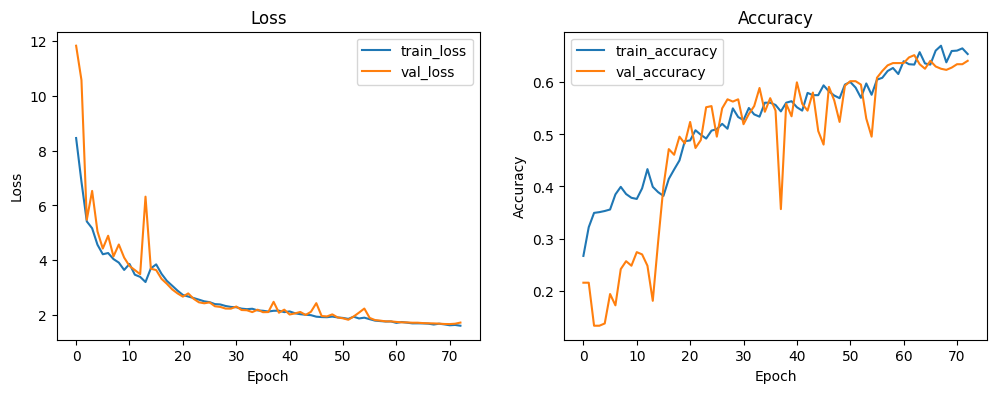

In [ ]:

# Tracer les courbes de perte pour la formation et la validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer les courbes de précision pour l'entraînement et la validation
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


### C.Lerning Transfert

#### 1) VGG v1

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

# Créer le model
base_model_vgg16 = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model_vgg16.trainable = False  # Gel des couches de modèles pré-entraînés

model_vgg16 = Sequential([
    base_model_vgg16,
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compiler le modele
model_vgg16.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('vgg16_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Entraîner le modèle
history3 = model_vgg16.fit(X_train, y_train, batch_size=32, epochs=100,
              validation_data=(X_val, y_val),
              callbacks=[early_stopping, model_checkpoint, reduce_lr]
              )



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5592 - loss: 1.3039
Epoch 1: val_accuracy improved from -inf to 0.40217, saving model to vgg16_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.5609 - loss: 1.2986 - val_accuracy: 0.4022 - val_loss: 3.4130 - learning_rate: 0.0010
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8816 - loss: 0.4083
Epoch 2: val_accuracy improved from 0.40217 to 0.54565, saving model to vgg16_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 367s 8s/step - accuracy: 0.8816 - loss: 0.4083 - val_accuracy: 0.5457 - val_loss: 1.6069 - learning_rate: 0.0010
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9360 - loss: 0.2672
Epoch 3: val_accuracy improved from 0.54565 to 0.73478, saving model to vgg16_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 239s 6s/step - accuracy: 0.9359 - loss: 0.2669 - val_accuracy: 0.7348 - val_loss: 0.7533 - learning_rate: 0.0010
Epoch 4/10

In [ ]:

test_loss3, test_acc3 = model_vgg16.evaluate(X_test, y_test)
print('Test loss:', test_loss3)
print('Test accuracy:', test_acc3)

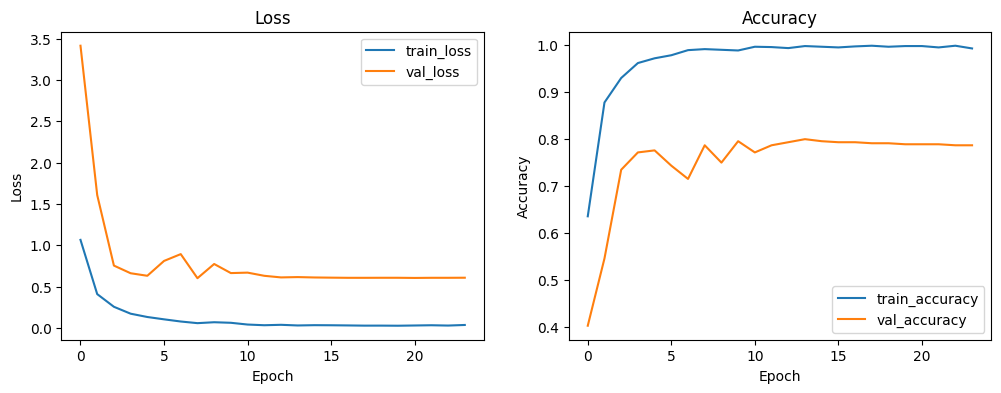

In [ ]:
# Tracer les courbes de perte pour la formation et la validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='train_loss')
plt.plot(history3.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer les courbes de précision pour l'entraînement et la validation
plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='train_accuracy')
plt.plot(history3.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# Décongélation de certaines couches pour un réglage fin
base_model_vgg16.trainable = True
for layer in base_model_vgg16.layers[:15]:
    layer.trainable = False

# Recompiler le modèle pour appliquer les modifications
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])


history_fine = model_vgg16.fit(
    image_data_generator.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/50


c:\Users\lisay\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7875 - loss: 0.7148
Epoch 1: val_accuracy did not improve from 0.80000
44/44 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7876 - loss: 0.7144 - val_accuracy: 0.7609 - val_loss: 0.9058 - learning_rate: 1.0000e-04
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8293 - loss: 0.4979
Epoch 2: val_accuracy improved from 0.80000 to 0.82174, saving model to vgg16_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8295 - loss: 0.4972 - val_accuracy: 0.8217 - val_loss: 0.6267 - learning_rate: 1.0000e-04
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8559 - loss: 0.4387
Epoch 3: val_accuracy did not improve from 0.82174
44/44 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8559 - loss: 0.4390 - val_accuracy: 0.8000 - val_loss: 0.6598 - learning_rate: 1.0000e-04
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8772 - loss: 0.3494
Epoch 4: val_accuracy did not improve from 0.82174
44/4

In [ ]:
test_loss3_fine, test_acc3_fine = model_vgg16.evaluate(X_test, y_test)
print('Test loss:', test_loss3_fine)
print('Test accuracy:', test_acc3_fine)

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8439 - loss: 0.6214
Test loss: 0.5459789633750916
Test accuracy: 0.8717391490936279


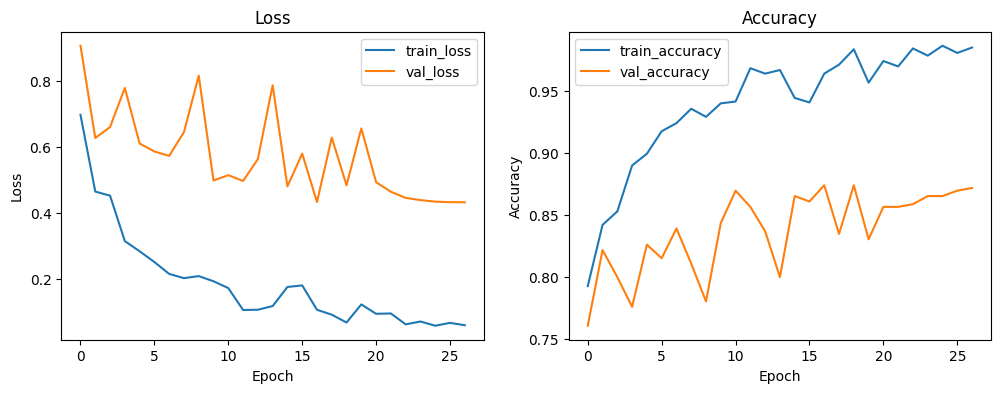

In [ ]:
# Tracer les courbes de perte pour la formation et la validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['loss'], label='train_loss')
plt.plot(history_fine.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer les courbes de précision pour l'entraînement et la validation
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['accuracy'], label='train_accuracy')
plt.plot(history_fine.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 1.2) VGG16 V2 :

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

#
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg16.trainable = False

model_vgg16_v2 = Sequential([
    base_model_vgg16,
    GlobalAveragePooling2D(),  # utiliser GlobalAveragePooling2D
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# model_vgg16_v2 = Sequential([
#     base_model_vgg16,
#     Flatten(),
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(7, activation='softmax')
# ])

#
model_vgg16_v2.compile(optimizer=Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

#
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v2.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

#
history_vgg16_v2 = model_vgg16_v2.fit(
    image_data_generator.flow(X_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 3.3479 - accuracy: 0.5022
Epoch 1: val_accuracy improved from -inf to 0.34565, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v2.h5
44/44 [==============================] - 19s 399ms/step - loss: 3.3479 - accuracy: 0.5022 - val_loss: 3.3026 - val_accuracy: 0.3457 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 2.5188 - accuracy: 0.6732
Epoch 2: val_accuracy improved from 0.34565 to 0.54565, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v2.h5
44/44 [==============================] - 17s 393ms/step - loss: 2.5188 - accuracy: 0.6732 - val_loss: 2.8676 - val_accuracy: 0.5457 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 2.0923 - accuracy: 0.7471
Epoch 3: val_accuracy improved from 0.54565 to 0.69348, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learni

In [ ]:
base_model_vgg16.trainable = True
for layer in base_model_vgg16.layers[:15]:
    layer.trainable = False

# recompile
model_vgg16_v2.compile(optimizer=Adam(learning_rate=0.0001),  # utiliser plus petite learning_rate
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# rentrainer
history_fine_vgg16_v2 = model_vgg16_v2.fit(
    image_data_generator.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



Epoch 1/50
 7/44 [===>..........................] - ETA: 9s - loss: 2.1152 - accuracy: 0.1696

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import load_model
model_vgg16_2 = load_model('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v2.h5')

test_loss, test_acc = model_vgg16_2.evaluate(X_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

15/15 [==============================] - 3s 222ms/step - loss: 0.3240 - accuracy: 0.9479
Test loss: 0.32402828335762024
Test accuracy: 0.9479392766952515


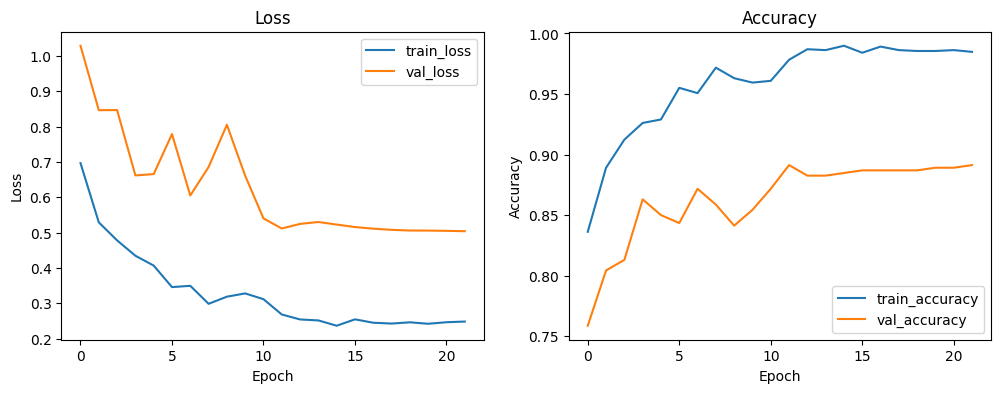

In [ ]:
# Tracer les courbes de perte pour la formation et la validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine_vgg16_v2.history['loss'], label='train_loss')
plt.plot(history_fine_vgg16_v2.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer les courbes de précision pour l'entraînement et la validation
plt.subplot(1, 2, 2)
plt.plot(history_fine_vgg16_v2.history['accuracy'], label='train_accuracy')
plt.plot(history_fine_vgg16_v2.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 1.2) VGG16 v3

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

#
base_model_vgg16_v3 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg16_v3.trainable = False

model_vgg16_v3 = Sequential([
    base_model_vgg16_v3,
    GlobalAveragePooling2D(),  # utiliser GlobalAveragePooling2D
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.7),
    Dense(7, activation='softmax')
])

#
model_vgg16_v3.compile(optimizer=Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

#
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v3.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

#
history_vgg16_v3 = model_vgg16_v3.fit(
    image_data_generator.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

base_model_vgg16_v3.trainable = True
for layer in base_model_vgg16_v3.layers[:15]:
    layer.trainable = False

# recompile
model_vgg16_v3.compile(optimizer=Adam(learning_rate=0.0001),  # utiliser plus petite learning_rate
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# rentrainer
history_fine_vgg16_v3 = model_vgg16_v3.fit(
    image_data_generator.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 3.8022 - accuracy: 0.3906
Epoch 1: val_accuracy improved from -inf to 0.44130, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 27s 394ms/step - loss: 3.8022 - accuracy: 0.3906 - val_loss: 3.4007 - val_accuracy: 0.4413 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 2.8652 - accuracy: 0.5942
Epoch 2: val_accuracy improved from 0.44130 to 0.58043, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v3.h5
44/44 [==============================] - 16s 362ms/step - loss: 2.8652 - accuracy: 0.5942 - val_loss: 3.0346 - val_accuracy: 0.5804 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 2.4988 - accuracy: 0.6384
Epoch 3: val_accuracy improved from 0.58043 to 0.68913, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v3.h5
44/44 [==============================] - 19s 424ms/step - loss: 2.4988 - accuracy: 0.6384 - val_loss: 2.7253 - val_accuracy: 0.6891 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - ETA: 0s - loss: 2.1

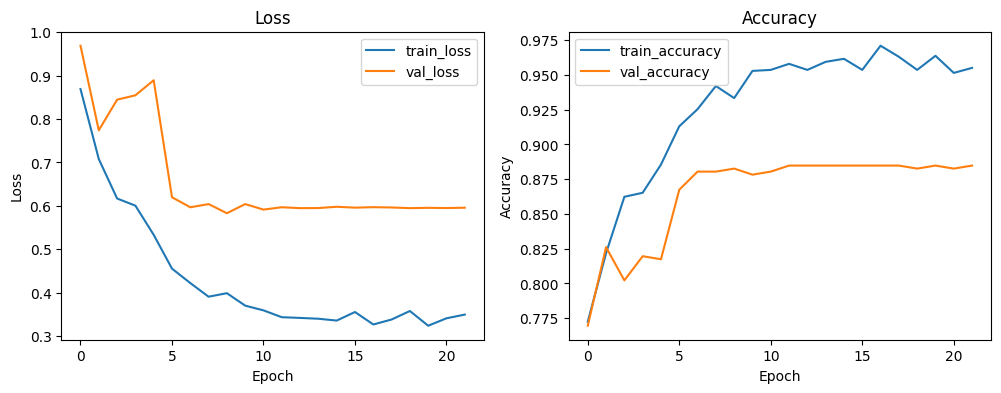

In [ ]:
# Tracer les courbes de perte pour la formation et la validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine_vgg16_v3.history['loss'], label='train_loss')
plt.plot(history_fine_vgg16_v3.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer les courbes de précision pour l'entraînement et la validation
plt.subplot(1, 2, 2)
plt.plot(history_fine_vgg16_v3.history['accuracy'], label='train_accuracy')
plt.plot(history_fine_vgg16_v3.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
from tensorflow.keras.models import load_model
model_vgg16_v3 = load_model('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v3.h5')

test_loss_v3, test_acc_v3 = model_vgg16_v3.evaluate(X_test, y_test)
print('Test loss:', test_loss_v3)
print('Test accuracy:', test_acc_v3)

15/15 [==============================] - 2s 86ms/step - loss: 0.5667 - accuracy: 0.8850
Test loss: 0.5667060613632202
Test accuracy: 0.8850325345993042


#### 1.3) VGG16 v4

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

#
base_model_vgg16_v4 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg16_v4.trainable = False

model_vgg16_v4 = Sequential([
    base_model_vgg16_v4,
    GlobalAveragePooling2D(),  # utiliser GlobalAveragePooling2D
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.7),
    Dense(7, activation='softmax')
])

#
model_vgg16_v4.compile(optimizer=Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

#
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v3.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

#
history_vgg16_v4 = model_vgg16_v4.fit(
    image_data_generator.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

base_model_vgg16_v4.trainable = True
for layer in base_model_vgg16_v4.layers[:15]:
    layer.trainable = False

# recompile
model_vgg16_v4.compile(optimizer=Adam(learning_rate=0.0001),  # utiliser plus petite learning_rate
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# rentrainer
history_fine_vgg16_v4 = model_vgg16_v3.fit(
    image_data_generator.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 3.8022 - accuracy: 0.3906
Epoch 1: val_accuracy improved from -inf to 0.44130, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 27s 394ms/step - loss: 3.8022 - accuracy: 0.3906 - val_loss: 3.4007 - val_accuracy: 0.4413 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 2.8652 - accuracy: 0.5942
Epoch 2: val_accuracy improved from 0.44130 to 0.58043, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v3.h5
44/44 [==============================] - 16s 362ms/step - loss: 2.8652 - accuracy: 0.5942 - val_loss: 3.0346 - val_accuracy: 0.5804 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 2.4988 - accuracy: 0.6384
Epoch 3: val_accuracy improved from 0.58043 to 0.68913, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v3.h5
44/44 [==============================] - 19s 424ms/step - loss: 2.4988 - accuracy: 0.6384 - val_loss: 2.7253 - val_accuracy: 0.6891 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - ETA: 0s - loss: 2.1

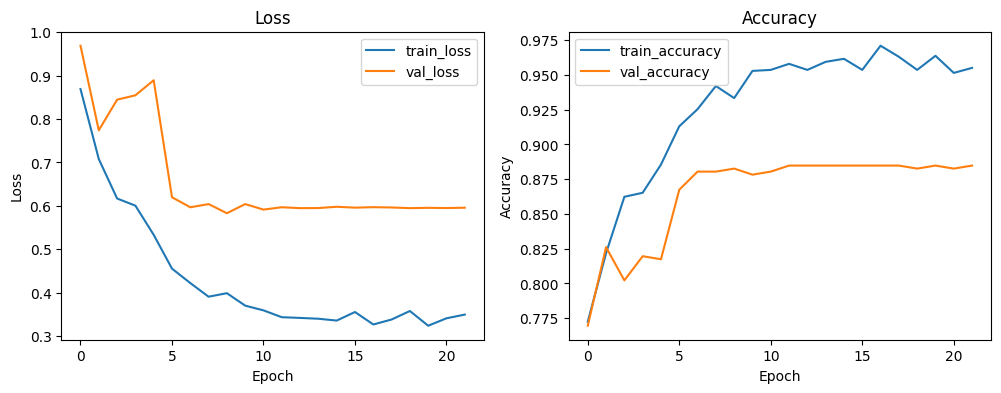

In [ ]:
# Tracer les courbes de perte pour la formation et la validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_fine_vgg16_v4.history['loss'], label='train_loss')
plt.plot(history_fine_vgg16_v4.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer les courbes de précision pour l'entraînement et la validation
plt.subplot(1, 2, 2)
plt.plot(history_fine_vgg16_v4.history['accuracy'], label='train_accuracy')
plt.plot(history_fine_vgg16_v4.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
from tensorflow.keras.models import load_model
model_vgg16_v3 = load_model('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v3.h5')

test_loss_v3, test_acc_v3 = model_vgg16_v3.evaluate(X_test, y_test)
print('Test loss:', test_loss_v3)
print('Test accuracy:', test_acc_v3)

15/15 [==============================] - 2s 86ms/step - loss: 0.5667 - accuracy: 0.8850
Test loss: 0.5667060613632202
Test accuracy: 0.8850325345993042


#### 2) DenseNet121

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

#
base_model_denseNet121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_denseNet121.trainable = False

model_denseNet121 = Sequential([
    base_model_denseNet121,
    GlobalAveragePooling2D(),  # utiliser GlobalAveragePooling2D
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


#
model_denseNet121.compile(optimizer=Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

#
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_denseNet121.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

#
history_denseNet121_1 = model_denseNet121.fit(
    image_data_generator.flow(X_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

base_model_denseNet121.trainable = True
for layer in base_model_denseNet121.layers[:15]:
    layer.trainable = False

# recompile
model_denseNet121.compile(optimizer=Adam(learning_rate=0.0001),  # utiliser plus petite learning_rate
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# rentrainer
history_denseNet121_2 = model_denseNet121.fit(
    image_data_generator.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



Epoch 1/100
43/44 [============================>.] - ETA: 0s - loss: 2.9266 - accuracy: 0.6003
Epoch 1: val_accuracy improved from -inf to 0.75217, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_denseNet121.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 25s 423ms/step - loss: 2.9258 - accuracy: 0.6000 - val_loss: 2.1036 - val_accuracy: 0.7522 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 1.7982 - accuracy: 0.8065
Epoch 2: val_accuracy improved from 0.75217 to 0.82174, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_denseNet121.h5
44/44 [==============================] - 16s 374ms/step - loss: 1.7982 - accuracy: 0.8065 - val_loss: 1.6089 - val_accuracy: 0.8217 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 1.4881 - accuracy: 0.8304
Epoch 3: val_accuracy improved from 0.82174 to 0.85435, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_denseNet121.h5
44/44 [==============================] - 16s 373ms/step - loss: 1.4881 - accuracy: 0.8304 - val_loss: 1.3700 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - ETA: 0s - 

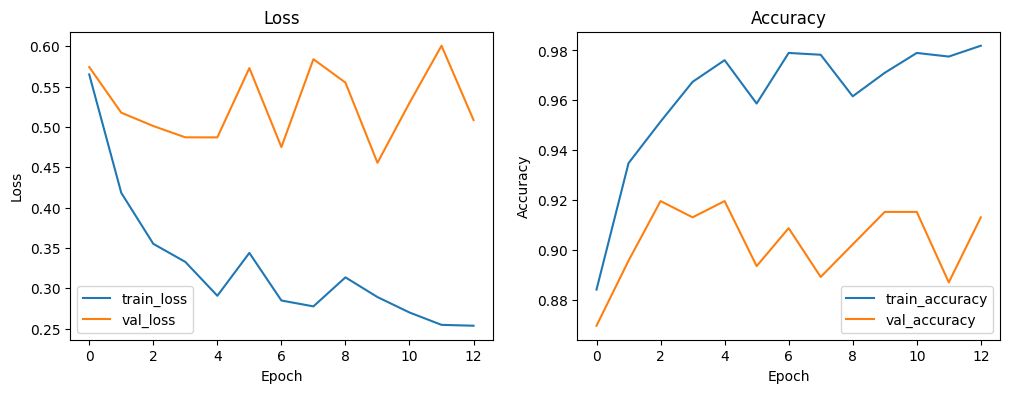

In [ ]:
# Tracer les courbes de perte pour la formation et la validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_denseNet121_2.history['loss'], label='train_loss')
plt.plot(history_denseNet121_2.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer les courbes de précision pour l'entraînement et la validation
plt.subplot(1, 2, 2)
plt.plot(history_denseNet121_2.history['accuracy'], label='train_accuracy')
plt.plot(history_denseNet121_2.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model_denseNet121 = load_model('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_denseNet121.h5')
test_loss_denseNet121, test_acc_denseNet121 = model_denseNet121.evaluate(X_test, y_test)
print('Test loss:', test_loss_denseNet121)
print('Test accuracy:', test_acc_denseNet121)

15/15 [==============================] - 3s 71ms/step - loss: 0.5200 - accuracy: 0.9002
Test loss: 0.520048975944519
Test accuracy: 0.9002169370651245


#### 2.1) DenseNet121 V2

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

#
base_model_denseNet121_v2 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_denseNet121_v2.trainable = False

model_denseNet121_v2 = Sequential([
    base_model_denseNet121_v2,
    GlobalAveragePooling2D(),  # utiliser GlobalAveragePooling2D
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.7),
    Dense(7, activation='softmax')
])


#
model_denseNet121_v2.compile(optimizer=Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

#
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_denseNet121_v2.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

#
history_denseNet121_v2_1 = model_denseNet121_v2.fit(
    image_data_generator.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

base_model_denseNet121_v2.trainable = True
for layer in base_model_denseNet121_v2.layers[:15]:
    layer.trainable = False

# recompile
model_denseNet121_v2.compile(optimizer=Adam(learning_rate=0.0001),  # utiliser plus petite learning_rate
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# rentrainer
history_denseNet121_v2_2 = model_denseNet121_v2.fit(
    image_data_generator.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



Epoch 1/50
44/44 [==============================] - ETA: 0s - loss: 3.3082 - accuracy: 0.4891
Epoch 1: val_accuracy improved from -inf to 0.74565, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_denseNet121_v2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 24s 401ms/step - loss: 3.3082 - accuracy: 0.4891 - val_loss: 2.2539 - val_accuracy: 0.7457 - lr: 0.0010
Epoch 2/50
44/44 [==============================] - ETA: 0s - loss: 2.1235 - accuracy: 0.7145
Epoch 2: val_accuracy improved from 0.74565 to 0.81304, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_denseNet121_v2.h5
44/44 [==============================] - 16s 372ms/step - loss: 2.1235 - accuracy: 0.7145 - val_loss: 1.7606 - val_accuracy: 0.8130 - lr: 0.0010
Epoch 3/50
44/44 [==============================] - ETA: 0s - loss: 1.7717 - accuracy: 0.7942
Epoch 3: val_accuracy improved from 0.81304 to 0.85435, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_denseNet121_v2.h5
44/44 [==============================] - 16s 370ms/step - loss: 1.7717 - accuracy: 0.7942 - val_loss: 1.5160 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 4/50
44/44 [==============================] - ETA: 0s

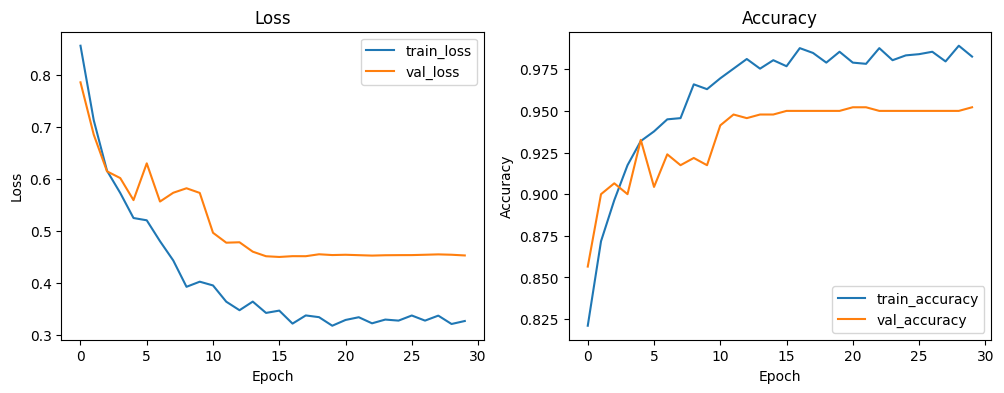

In [ ]:
# Tracer les courbes de perte pour la formation et la validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_denseNet121_v2_2.history['loss'], label='train_loss')
plt.plot(history_denseNet121_v2_2.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer les courbes de précision pour l'entraînement et la validation
plt.subplot(1, 2, 2)
plt.plot(history_denseNet121_v2_2.history['accuracy'], label='train_accuracy')
plt.plot(history_denseNet121_v2_2.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model_denseNet121_v2 = load_model('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_denseNet121_v2.h5')
test_loss_denseNet121_v2, test_acc_denseNet121_v2 = model_denseNet121_v2.evaluate(X_test, y_test)
print('Test loss:', test_loss_denseNet121_v2)
print('Test accuracy:', test_acc_denseNet121_v2)

15/15 [==============================] - 3s 55ms/step - loss: 0.4416 - accuracy: 0.9436
Test loss: 0.4415706396102905
Test accuracy: 0.9436008930206299


#### 3) Xception

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

#
base_model_Xception = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_Xception.trainable = False

model_Xception = Sequential([
    base_model_Xception,
    GlobalAveragePooling2D(),  # utiliser GlobalAveragePooling2D
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


#
model_Xception.compile(optimizer=Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

#
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_Xception.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

#
history_Xception_1 = model_Xception.fit(
    image_data_generator.flow(X_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

base_model_Xception.trainable = True
for layer in base_model_Xception.layers[:15]:
    layer.trainable = False

# recompile
model_Xception.compile(optimizer=Adam(learning_rate=0.0001),  # utiliser plus petite learning_rate
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# rentrainer
history_Xception_2 = model_Xception.fit(
    image_data_generator.flow(X_train, y_train, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



Epoch 1/100
44/44 [==============================] - ETA: 0s - loss: 3.5615 - accuracy: 0.6196
Epoch 1: val_accuracy improved from -inf to 0.83478, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_Xception.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 21s 372ms/step - loss: 3.5615 - accuracy: 0.6196 - val_loss: 2.9090 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 2/100
44/44 [==============================] - ETA: 0s - loss: 2.6853 - accuracy: 0.8130
Epoch 2: val_accuracy improved from 0.83478 to 0.85870, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_Xception.h5
44/44 [==============================] - 17s 385ms/step - loss: 2.6853 - accuracy: 0.8130 - val_loss: 2.5019 - val_accuracy: 0.8587 - lr: 0.0010
Epoch 3/100
44/44 [==============================] - ETA: 0s - loss: 2.3729 - accuracy: 0.8196
Epoch 3: val_accuracy did not improve from 0.85870
44/44 [==============================] - 15s 335ms/step - loss: 2.3729 - accuracy: 0.8196 - val_loss: 2.1957 - val_accuracy: 0.8478 - lr: 0.0010
Epoch 4/100
44/44 [==============================] - ETA: 0s - loss: 2.0962 - accuracy: 0.8442
Epoch 4: val_accuracy improved from 0.85870 to 0.86304, saving model to /con

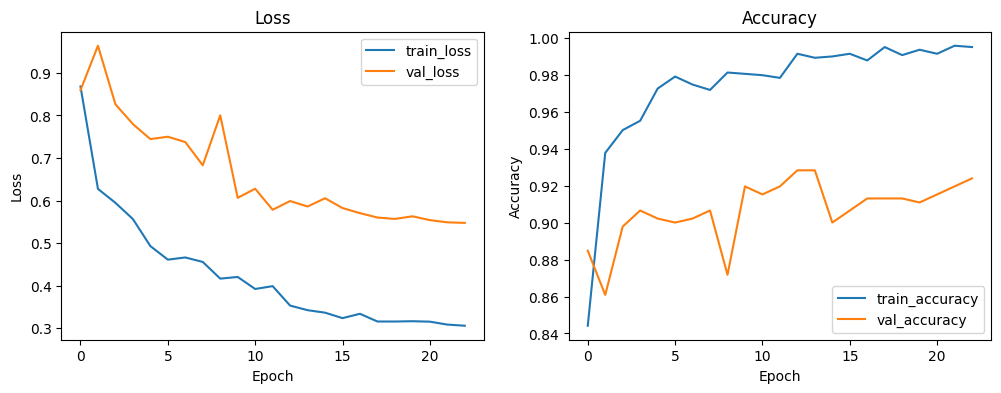

In [ ]:
# Tracer les courbes de perte pour la formation et la validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_Xception_2.history['loss'], label='train_loss')
plt.plot(history_Xception_2.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer les courbes de précision pour l'entraînement et la validation
plt.subplot(1, 2, 2)
plt.plot(history_Xception_2.history['accuracy'], label='train_accuracy')
plt.plot(history_Xception_2.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model_Xception = load_model('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_Xception.h5')
test_loss_Xception, test_acc_Xception = model_Xception.evaluate(X_test, y_test)
print('Test loss:', test_loss_Xception)
print('Test accuracy:', test_acc_Xception)

15/15 [==============================] - 2s 66ms/step - loss: 0.6713 - accuracy: 0.9089
Test loss: 0.6713178157806396
Test accuracy: 0.9088937044143677


#### 3.1) Xception

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

#
base_model_Xception_v2 = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_Xception_v2.trainable = False

model_Xception_v2 = Sequential([
    base_model_Xception_v2,
    GlobalAveragePooling2D(),  # utiliser GlobalAveragePooling2D
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.05)),
    Dropout(0.7),
    Dense(7, activation='softmax')
])


#
model_Xception_v2.compile(optimizer=Adam(learning_rate=0.001),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

#
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_Xception_v2.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

#
history_Xception_v2_1 = model_Xception_v2.fit(
    image_data_generator.flow(X_train, y_train, batch_size=16),
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

base_model_Xception_v2.trainable = True
for layer in base_model_Xception_v2.layers[:15]:
    layer.trainable = False

# recompile
model_Xception_v2.compile(optimizer=Adam(learning_rate=0.0001),  # utiliser plus petite learning_rate
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# rentrainer
history_Xception_v2_2 = model_Xception_v2.fit(
    image_data_generator.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)



Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 11.0690 - accuracy: 0.5826
Epoch 1: val_accuracy improved from -inf to 0.83261, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_Xception_v2.h5
87/87 [==============================] - 19s 184ms/step - loss: 11.0690 - accuracy: 0.5826 - val_loss: 7.7272 - val_accuracy: 0.8326 - lr: 0.0010
Epoch 2/50
87/87 [==============================] - ETA: 0s - loss: 6.2655 - accuracy: 0.7123
Epoch 2: val_accuracy did not improve from 0.83261
87/87 [==============================] - 15s 172ms/step - loss: 6.2655 - accuracy: 0.7123 - val_loss: 4.5199 - val_accuracy: 0.8261 - lr: 0.0010
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 3.8894 - accuracy: 0.7543
Epoch 3: val_accuracy improved from 0.83261 to 0.85652, saving model to /content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_Xception_v2.h5
87/87 [==============================] - 16s 188ms/step - loss: 3.

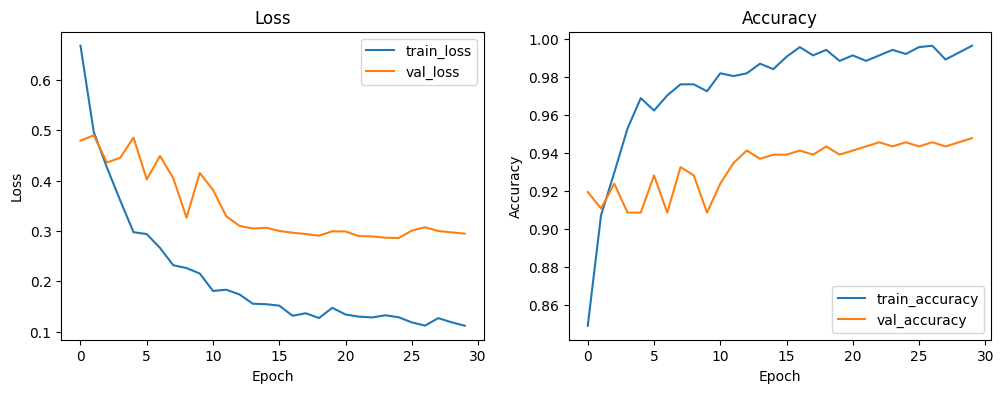

In [ ]:
# Tracer les courbes de perte pour la formation et la validation
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_Xception_v2_2.history['loss'], label='train_loss')
plt.plot(history_Xception_v2_2.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Tracer les courbes de précision pour l'entraînement et la validation
plt.subplot(1, 2, 2)
plt.plot(history_Xception_v2_2.history['accuracy'], label='train_accuracy')
plt.plot(history_Xception_v2_2.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model_Xception_v2 = load_model('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_Xception_v2.h5')
test_loss_Xception_v2, test_acc_Xception_v2 = model_Xception.evaluate(X_test, y_test)
print('Test loss:', test_loss_Xception_v2)
print('Test accuracy:', test_acc_Xception_v2)

15/15 [==============================] - 1s 65ms/step - loss: 0.6713 - accuracy: 0.9089
Test loss: 0.6713178157806396
Test accuracy: 0.9088937044143677


## III. Tester les modeles

### A. modele VGG16 v2

1/1 [==============================] - 0s 173ms/step


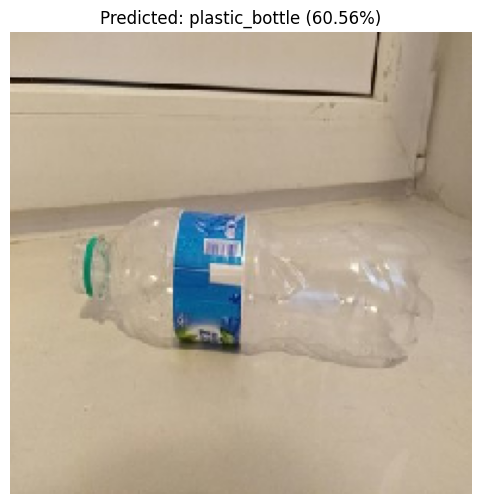

Predicted class: plastic_bottle
Probability: 60.56%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

# charger le modele
model = load_model('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v2.h5')

# choisir image
img_path = '/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/dataset-master/plastic_bottle/1OhhNKhish8.jpg'

img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

#
predictions = model.predict(img_array)

# index + probabilité
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_prob = np.max(predictions, axis=1)[0]

# convertir le laben en nom de dossier
predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]


plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label} ({predicted_prob*100:.2f}%)')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print(f'Probability: {predicted_prob*100:.2f}%')


1/1 [==============================] - 0s 183ms/step


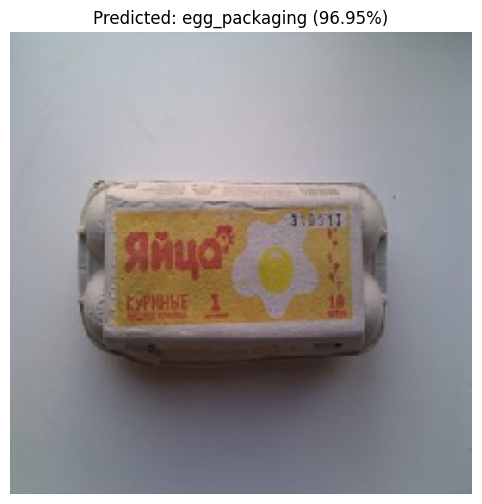

Predicted class: egg_packaging
Probability: 96.95%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

# charger le modele
model = load_model('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v2.h5')

# choisir image
img_path = '/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/dataset-master/egg_packaging/1woop_flMgk.jpg'

img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

#
predictions = model.predict(img_array)

# index + probabilité
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_prob = np.max(predictions, axis=1)[0]

# convertir le laben en nom de dossier
predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]


plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.title(f'Predicted: {predicted_class_label} ({predicted_prob*100:.2f}%)')
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class_label}')
print(f'Probability: {predicted_prob*100:.2f}%')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.preprocessing import LabelEncoder
import os
import random
import pickle

model = load_model('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_vgg16_v2.h5')

with open('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

main_folder = '/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/dataset-master'

image_paths = []
for subdir, _, files in os.walk(main_folder):
    for file in files:
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(subdir, file))


random_image_paths = random.sample(image_paths, 25)

plt.figure(figsize=(20, 20))

for i, img_path in enumerate(random_image_paths):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    true_label = os.path.basename(os.path.dirname(img_path))

    # prédire
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_prob = np.max(predictions, axis=1)[0]
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]

    # verifier si c'est correcte
    if predicted_class_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    # afficher
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.title(f'{predicted_class_label} ({predicted_prob*100:.2f}%)', color=color)
    plt.axis('off')

plt.show()


Output hidden; open in https://colab.research.google.com to view.

### B. DenseNet121 v2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.preprocessing import LabelEncoder
import os
import random
import pickle

model = load_model('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/model_denseNet121_v2.h5')

with open('/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

main_folder = '/content/drive/MyDrive/2023-2024/S8/Machine Learning II/Projet/dataset-master'

image_paths = []
for subdir, _, files in os.walk(main_folder):
    for file in files:
        if file.endswith('.jpg'):
            image_paths.append(os.path.join(subdir, file))


random_image_paths = random.sample(image_paths, 25)

plt.figure(figsize=(20, 20))

for i, img_path in enumerate(random_image_paths):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    true_label = os.path.basename(os.path.dirname(img_path))

    # prédire
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_prob = np.max(predictions, axis=1)[0]
    predicted_class_label = label_encoder.inverse_transform([predicted_class_index])[0]

    # verifier si c'est correcte
    if predicted_class_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    # afficher
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.title(f'{predicted_class_label} ({predicted_prob*100:.2f}%)', color=color)
    plt.axis('off')

plt.show()


Output hidden; open in https://colab.research.google.com to view.